In [79]:
%pylab inline

import numpy as np
import pandas as pd

data = pd.read_csv("gtex_capillary_summary.tsv", sep="\t")

########### Filters + preprocessing ###############
# Filter non-STR loci (AMEL, Yindel)
data = data[data["Marker"].apply(lambda x: x not in ["AMEL", "Yindel"])]

# Convert all gts to floats
for col in ["Allele1 - Cap", "Allele2 - Cap", "Allele1 - WGS", "Allele2 - WGS"]:
    data[col] = data[col].apply(float)

# Filter no call
data = data[~np.isnan(data["Allele1 - WGS"])]
data = data[~(np.isnan(data["Allele1 - Cap"]) & np.isnan(data["Allele2 - Cap"]))]

# Locus offsets
data["Offset"] = 0
data.ix[data["Marker"]=="D19S433", "Offset"] = 2
data.ix[data["Marker"]=="vWA", "Offset"] = 2
for col in ["Allele1 - Cap", "Allele2 - Cap"]:
    data[col] = data[col]+data["Offset"]

########### Compute quality metrics ###############

def GetGenotypeConcordance(x):
    return int((x["Allele1 - Cap"] == x["Allele1 - WGS"] and
        x["Allele2 - Cap"] == x["Allele2 - WGS"]) or \
        (x["Allele1 - Cap"] == x["Allele2 - WGS"] and
        x["Allele2 - Cap"] == x["Allele1 - WGS"]))
 
def GetGenotypeConcordanceINT(x):
    return int((int(x["Allele1 - Cap"]) == int(x["Allele1 - WGS"]) and
        int(x["Allele2 - Cap"]) == int(x["Allele2 - WGS"])) or \
        (int(x["Allele1 - Cap"]) == int(x["Allele2 - WGS"]) and
        int(x["Allele2 - Cap"]) == int(x["Allele1 - WGS"])))

data["gtconcordance"] = data.apply(GetGenotypeConcordance, 1)
data["gtconcordance_int"] = data.apply(GetGenotypeConcordanceINT, 1)

########### Summarize concordance by sample ###############
perlocus = data.groupby("Sample ID", as_index=False).agg({"gtconcordance": np.mean, "Marker": len})
perlocus.sort_values("gtconcordance", ascending=False)

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,Sample ID,Marker,gtconcordance
120,GTEX-WYJK,19,1.000000
131,GTEX-XBED,19,0.947368
53,GTEX-QXCU,19,0.947368
127,GTEX-X585,19,0.947368
104,GTEX-VUSH,19,0.947368
58,GTEX-RM2N,19,0.947368
0,GTEX-N7MS,18,0.944444
111,GTEX-WHPG,19,0.894737
55,GTEX-R55E,19,0.894737
99,GTEX-UPJH,19,0.894737


In [80]:
filt_samples = ["GTEX-WHWD"]
########### Summarize concordance by locus ###############
perlocus = data[data["Sample ID"].apply(lambda x: x not in filt_samples)].groupby("Marker", as_index=False).agg({"gtconcordance": np.mean, \
                                                           "gtconcordance_int": np.mean, "Sample ID": len})
perlocus.sort_values("gtconcordance_int", ascending=False)

,Marker,Sample ID,gtconcordance_int,gtconcordance
9,D2S441,141,1.000000,0.936170
16,TH01,141,1.000000,0.531915
0,CSF1PO,141,0.985816,0.985816
3,D13S317,141,0.978723,0.432624
14,DYS391,88,0.977273,0.977273
17,TPOX,138,0.971014,0.971014
10,D3S1358,141,0.964539,0.964539
13,D8S1179,135,0.962963,0.962963
4,D16S539,141,0.950355,0.950355
12,D7S820,141,0.943262,0.943262


In [94]:
data[data["Marker"]=="D22S1045"]

,Sample ID,Marker,ID,Allele1 - Cap,Allele2 - Cap,Allele1 - WGS,Allele2 - WGS,Offset,gtconcordance,gtconcordance_int,cap_d,wgs_d
10,GTEX-N7MS,D22S1045,GTEX-N7MS:D22S1045,11.0,11.0,11.0,11.0,0,1,1,22.0,22.0
34,GTEX-N7MT,D22S1045,GTEX-N7MT:D22S1045,15.0,16.0,15.0,16.0,0,1,1,31.0,31.0
58,GTEX-NFK9,D22S1045,GTEX-NFK9:D22S1045,11.0,15.0,11.0,15.0,0,1,1,26.0,26.0
106,GTEX-NL4W,D22S1045,GTEX-NL4W:D22S1045,11.0,16.0,11.0,16.0,0,1,1,27.0,27.0
130,GTEX-NPJ7,D22S1045,GTEX-NPJ7:D22S1045,11.0,15.0,11.0,15.0,0,1,1,26.0,26.0
154,GTEX-NPJ8,D22S1045,GTEX-NPJ8:D22S1045,15.0,15.0,15.0,15.0,0,1,1,30.0,30.0
178,GTEX-O5YT,D22S1045,GTEX-O5YT:D22S1045,15.0,15.0,15.0,15.0,0,1,1,30.0,30.0
202,GTEX-O5YV,D22S1045,GTEX-O5YV:D22S1045,11.0,16.0,11.0,16.0,0,1,1,27.0,27.0
226,GTEX-O5YW,D22S1045,GTEX-O5YW:D22S1045,16.0,16.0,16.0,16.0,0,1,1,32.0,32.0
250,GTEX-OHPK,D22S1045,GTEX-OHPK:D22S1045,14.0,14.0,14.0,14.0,0,1,1,28.0,28.0


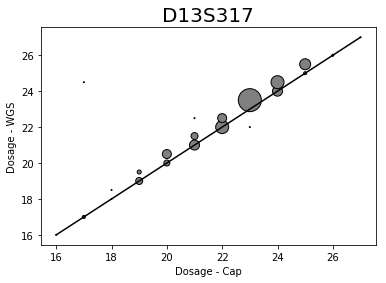

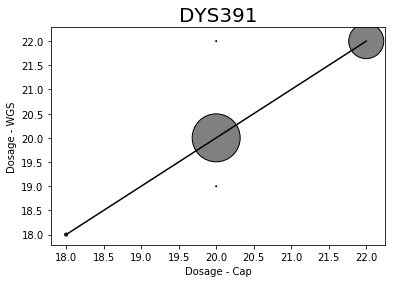

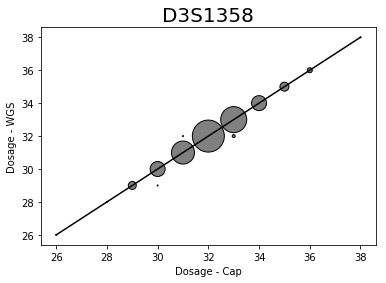

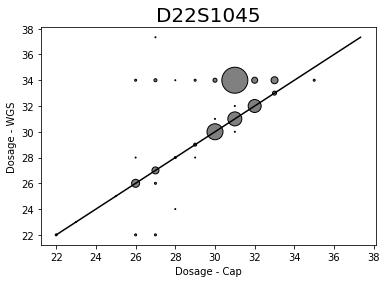

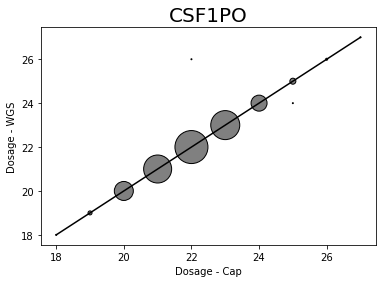

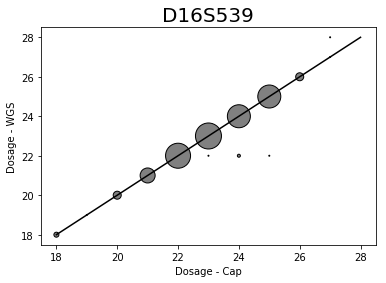

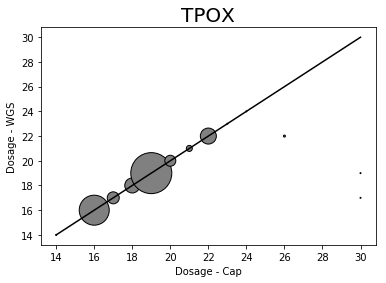

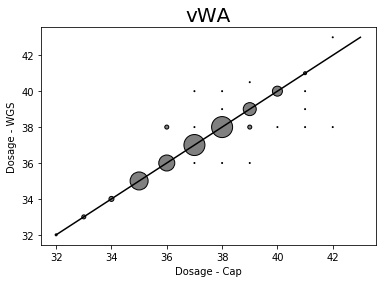

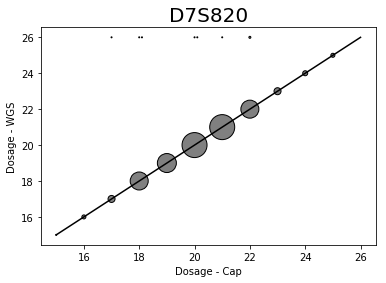

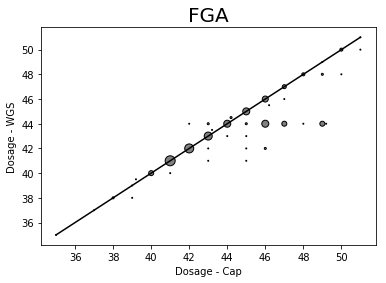

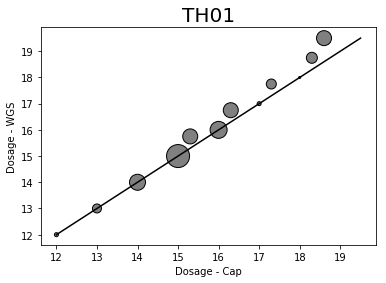

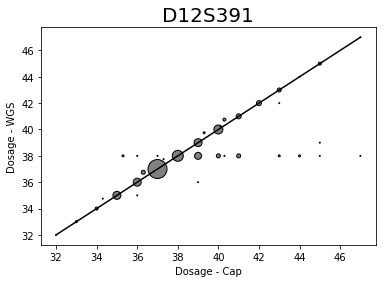

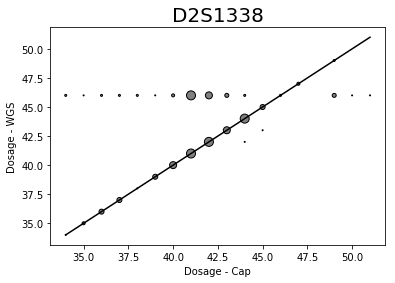

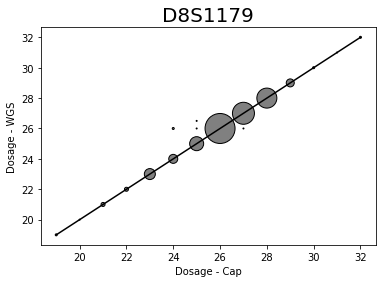

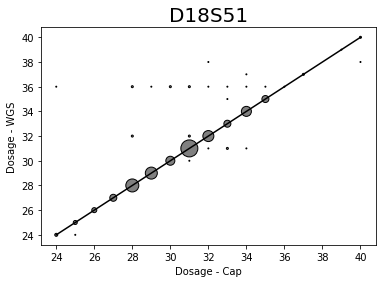

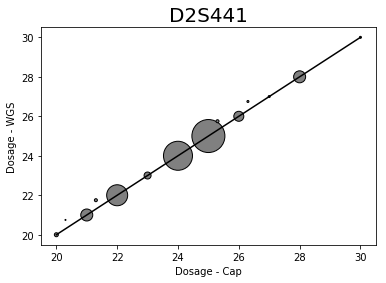

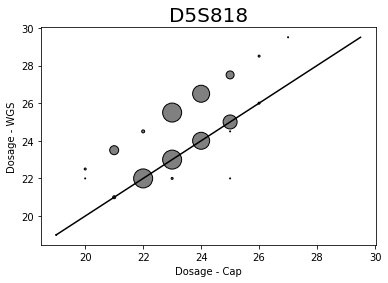

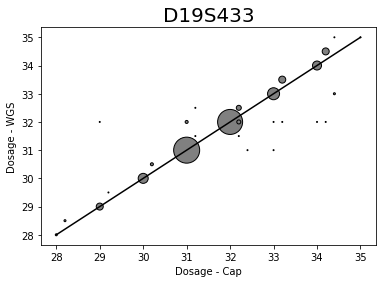

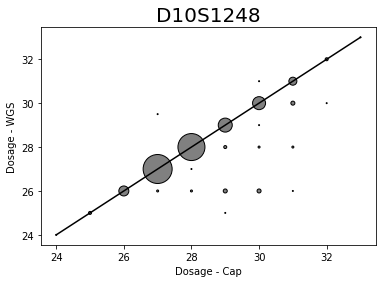

In [93]:
# Bubble plots
loci = set(data["Marker"])
data["cap_d"] = data["Allele1 - Cap"]+data["Allele2 - Cap"]
data["wgs_d"] = data["Allele1 - WGS"]+data["Allele2 - WGS"]
for l in loci:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    d = data[(data["Marker"]==l) & (data["Sample ID"].apply(lambda x: x not in filt_samples))]
    d = d.groupby(["cap_d","wgs_d"], as_index=False).agg({"Sample ID": len})
    ax.scatter(d["cap_d"], d["wgs_d"], s=d["Sample ID"]**2, color="gray", edgecolor="black")
    allvals = list(d["cap_d"])+list(d["wgs_d"])
    minval = min(allvals)
    maxval = max(allvals)
    ax.plot([minval, maxval], [minval, maxval], color="black")
    ax.set_xlabel("Dosage - Cap")
    ax.set_ylabel("Dosage - WGS")
    ax.set_title(l, size=20)